# Light Curve Similarity

Here we will demonstrate a proof of concept of the light curve similarity search. This notebook is available on GitHub at https://github.com/zclaytor/Light-Curve-Similarity-Search/AAS245_demo. Here I'm running it on the NASA Fornax platform (in development), but you can run it just as easily on the TIKE platform hosted by MAST (https://timeseries.science.stsci.edu).

First we must load in the test data, which in this case acts as our database.

In [1]:
import pandas as pd
import lightkurve as lk

data = pd.read_csv("../runs/classes_0/test_predictions.csv", 
    usecols=["TIC", "sector", "filename", "ebs_pred", "exo_pred", "flares_pred", "rot_pred"], 
    ).round(3)

data

,TIC,sector,filename,ebs_pred,exo_pred,flares_pred,rot_pred
0,366972961,25,tess2020133194932-s0025-0000000366972961-0182-...,1.000,0.000,0.000,0.000
1,349156098,31,tess2020294194027-s0031-0000000349156098-0198-...,0.000,1.000,0.000,0.000
2,139804406,1,tess2018206045859-s0001-0000000139804406-0120-...,0.000,0.677,0.323,0.000
3,237913194,28,tess2020212050318-s0028-0000000237913194-0190-...,0.000,0.996,0.004,0.000
4,238123653,7,tess2019006130736-s0007-0000000238123653-0131-...,0.000,0.000,0.000,1.000
...,...,...,...,...,...,...,...
690,264461976,32,tess2020324010417-s0032-0000000264461976-0200-...,0.482,0.005,0.109,0.405
691,339960875,7,tess2019006130736-s0007-0000000339960875-0131-...,0.566,0.199,0.219,0.017
692,343173162,24,tess2020106103520-s0024-0000000343173162-0180-...,0.000,0.000,0.000,1.000
693,350073391,26,tess2020160202036-s0026-0000000350073391-0188-...,0.000,0.000,0.000,1.000


This "database" holds information about the target ID, sector number, light curve file name, and information extracted from the convolutional neural network, which we will use to search on. In principle the database will include other useful metadata, such as stellar parameters, mean photometry, light curve statistics, and more.

Let's choose the first row of this table to be our test light curve. We'll measure this one against the database and search for the top 10 most similar light curves. First we must pop the row out of the table.

Test light curve:


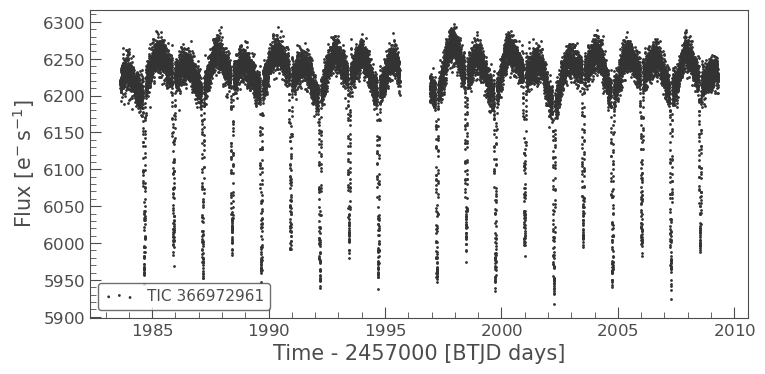

In [2]:
my_row = data.loc[0]
new_data = data.drop(0, axis=0)

import matplotlib.pyplot as plt
import os

def construct_path(filename):
    # convenience function to get the light curve path from the table row
    obs_id = filename.replace("_wt.npy", "")
    filepath = os.path.join("../mastDownload/TESS", obs_id, f"{obs_id}_lc.fits")
    return filepath

# read the light curve
mylc = lk.read(construct_path(my_row["filename"]))

# plot the light curve
print("Test light curve:")
ax = mylc.scatter()
plt.show()

This looks like a nice example of an eclipsing binary light curve.

We can compute the similarity to the other light curves using the euclidean distance between the classification prediction vectors, which are stored in the database. In practice, a special feature embedding vector will be computed from the Wavelet Transforms, which should result in more accurate matches. But for this demonstration, I'll just use the classification predictions.

First we compute the distance between our test light curve and the rest of the data, then sort by the distance.

In [3]:
import numpy as np
labels=["ebs", "exo", "flares", "rot"]
dist = np.sum([(my_row[l + "_pred"] - new_data[l + "_pred"])**2 for l in labels], axis=0)
sim_targets = new_data.iloc[np.argsort(dist)].round(1)
sim_targets

,TIC,sector,filename,ebs_pred,exo_pred,flares_pred,rot_pred
476,459789367,21,tess2020020091053-s0021-0000000459789367-0167-...,1.0,0.0,0.0,0.0
322,146879345,6,tess2018349182500-s0006-0000000146879345-0126-...,1.0,0.0,0.0,0.0
512,231922739,34,tess2021014023720-s0034-0000000231922739-0204-...,1.0,0.0,0.0,0.0
328,219373406,13,tess2019169103026-s0013-0000000219373406-0146-...,1.0,0.0,0.0,0.0
87,279323859,9,tess2019058134432-s0009-0000000279323859-0139-...,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
390,49174442,9,tess2019058134432-s0009-0000000049174442-0139-...,0.0,0.0,0.0,1.0
399,403224672,68,tess2023209231226-s0068-0000000403224672-0262-...,0.0,1.0,0.0,0.0
400,385012516,9,tess2019058134432-s0009-0000000385012516-0139-...,0.0,0.0,0.0,1.0
571,411883036,11,tess2019112060037-s0011-0000000411883036-0143-...,0.0,0.0,0.0,1.0


Now let's get the light curves and plot them.

Top 10 most similar:


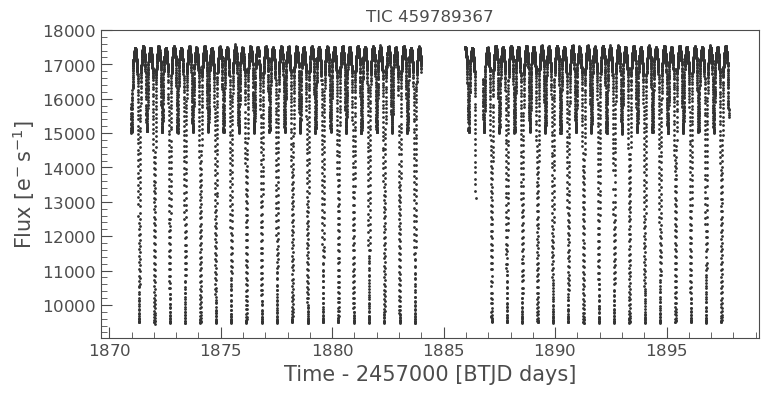

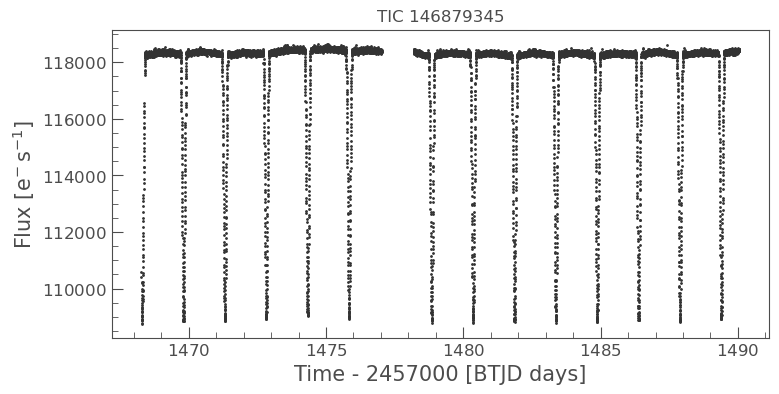

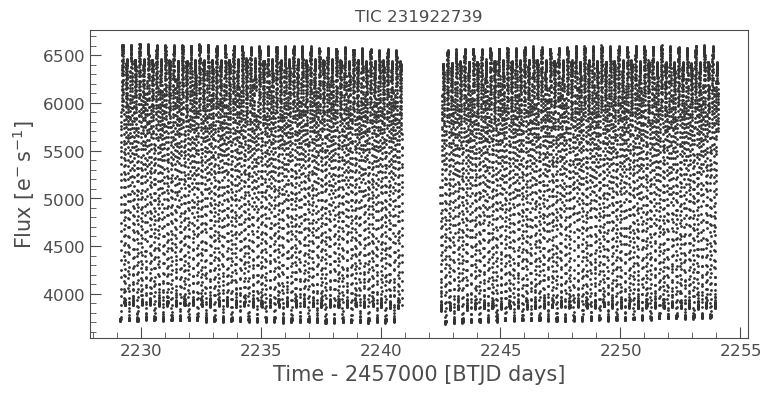

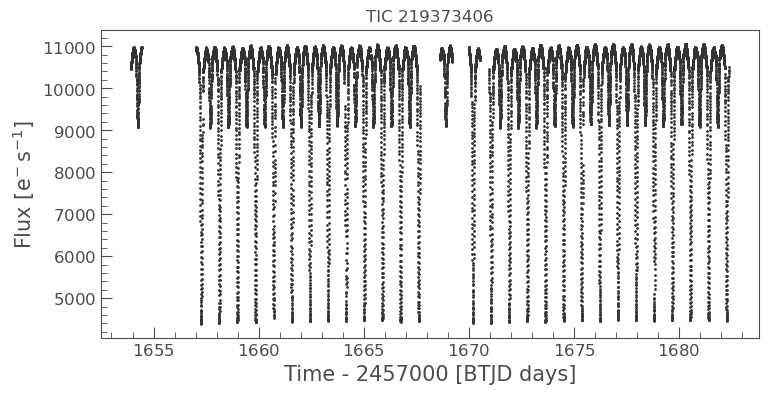

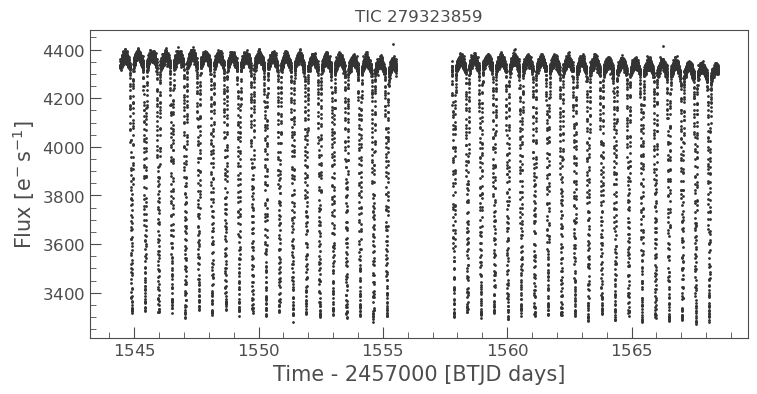

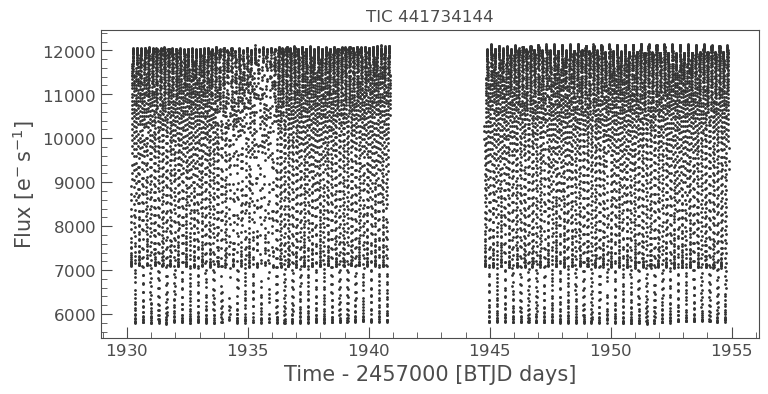

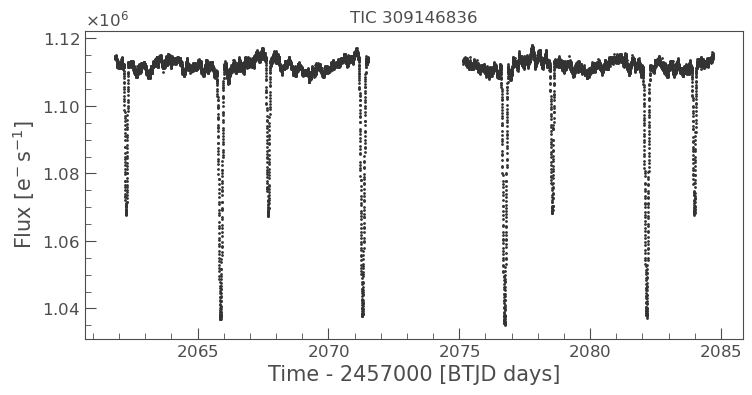

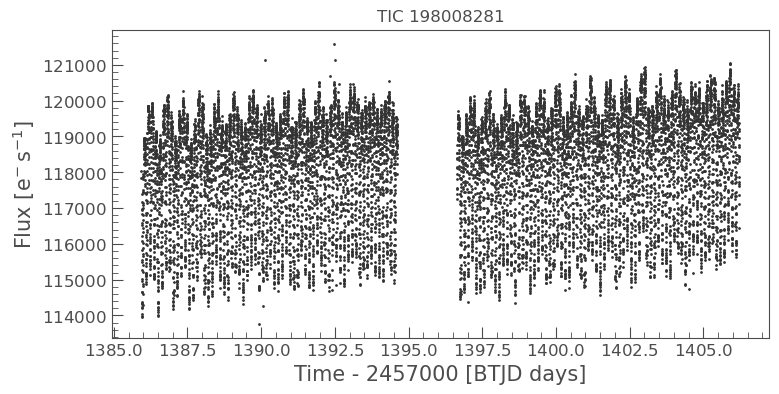

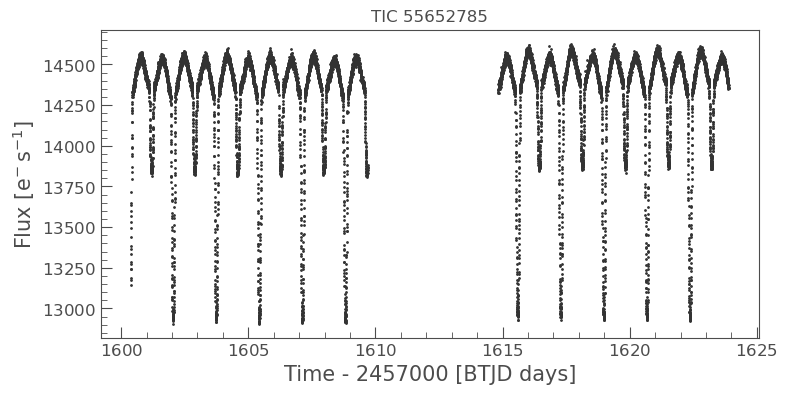

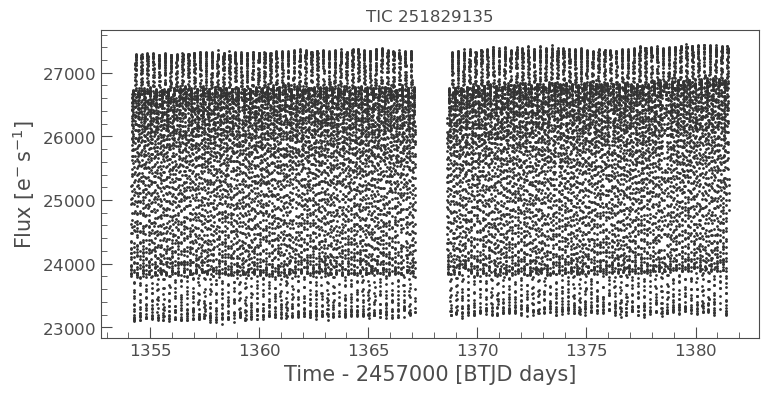

In [4]:
print("Top 10 most similar:")

top10 = sim_targets.iloc[:10]

plt.close("all")
for idx, row in top10.iterrows():
    fpath = construct_path(row["filename"])
    l = lk.read(fpath)
    ax = l.scatter()
    ax.legend().remove()
    ax.set_title(l.label)
    plt.show()

All 10 of the most similar light curves appear to be from eclipsing binary systems. Remember that, going in, we knew nothing about the nature of the light curves aside from what they look like. The similarity search is a great way to discover objects without knowing a priori how to search for them!

In practice, every light curve in the database will have a precomputed embedding, which is stored as a small array of floats. Comparing a light curve to other light curves in the database is fast, and in principle users will be able to upload their own light curve to match against the database.